# Northeast region of Brazil average temperature (August 2019) 

### Creating the adjacency matrix

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from pygsp import *
from scipy.spatial import distance
from gspy import *
import csv
import mplleaflet
import networkx as nx
import branca.colormap as cm

#########################################################
def degreesToRadians(degrees):
    return (degrees*np.pi/180)


def dist_km(lat1, lon1, lat2, lon2):
    earthRadiusKm = 6371

    dLat = degreesToRadians(lat2-lat1)
    dLon = degreesToRadians(lon2-lon1)

    lat1 = degreesToRadians(lat1)
    lat2 = degreesToRadians(lat2)

    a = np.sin(dLat/2)*np.sin(dLat/2)+np.sin(dLon/2)*np.sin(dLon/2)*np.cos(lat1)*np.cos(lat2) 
    c = 2*np.arctan(np.sqrt(a)/np.sqrt(1-a)); 
    return (earthRadiusKm*c);

#####################################
def m_adj(coords,k):
    
    Adj_K = np.zeros((len(coords),len(coords)))
    Aux = np.zeros((len(coords),1))
    aux = 0

    ind=np.zeros((k,1))
    for x in range(0,len(coords)):
        for y in range(0,len(coords)):
            v = [coords[x][0],coords[x][1]]
            w = [coords[y][0],coords[y][1]]
            dst = distance.euclidean(v,w)
            Aux[y]=dst
        ind = sorted(Aux)[1:k+1]
        for i in range(0,k):
            ind[i] = np.where(Aux == ind[i])
        for j in range(0,k):
            aux = ind[j][0]
            Adj_K[x][int(aux)] = np.exp((-Aux[ind[j]]**2))
            Adj_K[int(aux)][x] = Adj_K[x][int(aux)]

    
    return(Adj_K)

#####################################
def m_adj_w(coords,k,teta):
    
    Adj_K = np.zeros((len(coords),len(coords)))
    Aux = np.zeros((len(coords),1))
    aux = 0

    ind=np.zeros((k,1))
    for x in range(0,len(coords)):
        for y in range(0,len(coords)):
            v = [coords[x][0],coords[x][1]]
            w = [coords[y][0],coords[y][1]]
            dst = distance.euclidean(v,w)
            Aux[y]=dst
        ind = sorted(Aux)[1:k+1]
        for i in range(0,k):
            ind[i] = np.where(Aux == ind[i])
        for j in range(0,k):
            aux = ind[j][0]
            Adj_K[x][int(aux)] = np.exp((-Aux[ind[j]])/teta)
            #Adj_K[x][int(aux)] = 4
            #Adj_K[x][int(aux)] = Aux[ind[j]]
            Adj_K[int(aux)][x] = Adj_K[x][int(aux)]

    
    return(Adj_K)

#####################################
def m_adj_dist_km(coords,k,teta):
    
    Adj_K = np.zeros((len(coords),len(coords)))
    Aux = np.zeros((len(coords),1))
    aux = 0

    ind=np.zeros((k,1))
    for x in range(0,len(coords)):
        for y in range(0,len(coords)):
            v = [coords[x][0],coords[x][1]]
            w = [coords[y][0],coords[y][1]]
            dst = dist_Km(v[1],v[0],w[1],w[0])
            Aux[y]=dst
        ind = sorted(Aux)[1:k+1]
        for i in range(0,k):
            ind[i] = np.where(Aux == ind[i])
        for j in range(0,k):
            aux = ind[j][0]
            Adj_K[x][int(aux)] = np.exp((-Aux[ind[j]]**2)/teta)
            Adj_K[int(aux)][x] = Adj_K[x][int(aux)]

    
    return(Adj_K)

#df = pd.read_csv("/home/wallis/Área de Trabalho/ubuntu/TCC/zNE/NE_Temp3.txt",delimiter=';')
#df[96:97]

### Plotting graph signal using pygsp package

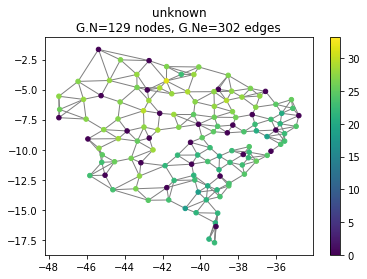

In [2]:
df = pd.read_csv("/home/wallis/Área de Trabalho/ubuntu/TCC/zNE/NE_Temp3.txt",delimiter=';')

Cte = len(df.temp_m)
coordinates = np.zeros((Cte,2))
signal = np.zeros((Cte,1))

for i in range(Cte):
    coordinates[i][1] = df.latitude[i]
    coordinates[i][0] = df.longitude[i]
    signal[i] = df.temp_m[i]

ind__ = np.array([6,114,55,74,17,35,119,89,33,65,63,70,60,96,79,85,0,125,81,94,106,113,5,91,27,86])
#ind__ = np.array([96])

for i in range(len(ind__)):
    signal[ind__[i]] = 0
        
A = adj_matrix_from_coords_limited(coordinates,4)
#A = m_adj(coordinates,1)
#A = m_adj_w(coordinates,4,1)
#A = m_adj_dist_km(coordinates,1,1)

G = graphs.Graph(A)

G.set_coordinates(coordinates)

plotting.plot_signal(G, signal, vertex_size = 20)

### Plotting graph signal on a map

In [3]:
###################################
G=nx.Graph()

lst = []

for i in range(0,len(signal)):
    lst.append(i)

G.add_nodes_from(lst)

#####################################
pos = []

for i in range(0,len(signal)):
    pos.append((coordinates[i][0],coordinates[i][1]))

edges = []

for i in range(0,len(A)):
    for j in range(0,len(A)):
        if A[i][j] > 0:
            edges.append((i,j))

pos_edges = []

for i in range(0,len(A)):
    pos_edges.append(((coordinates[edges[i][0]],coordinates[edges[i][0]]),(coordinates[edges[i][1]],coordinates[edges[i][1]])))
            
G.add_edges_from(edges)

#####################################
color = []

a = cm.linear.viridis.scale(0,max(signal))

#for i in range(0,len(coordinates)):
#    color.append(a.rgb_hex_str(signal[i]))

for i in range(0,len(coordinates)):
    if signal[i] > 0:
        color.append(a.rgb_hex_str(signal[i]))
    else:
        color.append('#000000')
        
#####################################
fig, ax = plt.subplots()

nx.draw_networkx_nodes(G,pos=pos,node_size=45,node_color=color,edge_color='k',alpha=1, with_labels=True)
nx.draw_networkx_edges(G,pos=pos,edge_color='black', alpha=.5)
nx.draw_networkx_labels(G,pos, label_pos =10.3)

mplleaflet.display(fig=ax.figure)
#tiles='mapbox bright'
#mplleaflet.show(fig=ax.figure)

/home/wallis/.local/lib/python3.6/site-packages/IPython/core/display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [4]:
a

### Estimated graph signal

In [5]:
from scipy.optimize import minimize
import scipy
from numpy import array
from numpy.linalg import norm

def L(Adj):
    
    degree = np.zeros((len(Adj),len(Adj))) 

    rowsum = Adj.sum(axis=1)

    for j in range(0, len(Adj)):
        degree[j][j] = rowsum[j]

    L = degree - Adj
    
    return(L)

Lp = L(A) 

#####################################
ind = []

for j in range (0,Cte):
    if signal[j] == 0:
        ind.append(j)

#####################################
s_est = []

def fun(n):
    
    sig = []
    
    for j in range (0,len(signal)):
        sig.append(signal[j])
        
    global s_est
    
    for i in range(len(n)):
        sig[ind[i]] = n[i]
    
    s_est = sig
    
    #st = np.reshape(s_est,(1,len(s_est)))
    #s_est = np.reshape(s_est,(len(s_est),1))
    
    #R = array(np.dot(st, Lp))
    #R = array(np.dot(R, s_est))
    #return(norm(R))

    R = array(np.dot(Lp, s_est))
    return(norm(R))

#####################################
x0 = []

for i in range(len(ind__)):
    x0.append(0)

#x0 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
#x0 = [0]

# 'BFGS' ‘Nelder-Mead’ ‘Powell’ ‘CG’ ‘Newton-CG’ ‘L-BFGS-B’ ‘TNC’ ‘COBYLA’ ‘SLSQP’ ‘trust-constr’
# ‘dogleg’ ‘trust-ncg’ ‘trust-exact’ ‘trust-krylov’
#fprime = lambda x: scipy.optimize.approx_fprime(x, fun, 0.01)
res = minimize(fun, x0, method='BFGS', options={'gtol': 1e-6, 'disp': True})
res.x

#####################################
G2=nx.Graph()

lst2 = []

for i in range(0,len(ind)):
    lst2.append(i)

G2.add_nodes_from(lst2)

#####################################
pos2 = []

for i in range(0,len(ind)):
    pos2.append((coordinates[ind[i]][0],coordinates[ind[i]][1]))


#####################################
G=nx.Graph()

lst = []

for i in range(0,len(s_est)):
    lst.append(i)

G.add_nodes_from(lst)

#####################################
pos = []

for i in range(0,len(s_est)):
    pos.append((coordinates[i][0],coordinates[i][1]))

edges = []

for i in range(0,len(A)):
    for j in range(0,len(A)):
        if A[i][j] > 0:
            edges.append((i,j))

pos_edges = []

for i in range(0,len(A)):
    pos_edges.append(((coordinates[edges[i][0]],coordinates[edges[i][0]]),(coordinates[edges[i][1]],coordinates[edges[i][1]])))
            
G.add_edges_from(edges)

#####################################
color = []
color2 = []
color3 = []

#a = cm.linear.RdBu_04.scale(0, 280)
a = cm.linear.viridis.scale(0, max(signal))

for i in range(0,len(coordinates)):
    color.append(a.rgb_hex_str(s_est[i]))

for i in range(0,len(ind)):
    color2.append("#FFFFFF")
    color3.append("#000000")
        
#####################################
fig, ax = plt.subplots()

nx.draw_networkx_nodes(G2,pos=pos2,node_size=130,node_color=color3,edge_color='k',alpha=1, with_labels=True)
nx.draw_networkx_nodes(G2,pos=pos2,node_size=100,node_color=color2,edge_color='k',alpha=1, with_labels=True)
nx.draw_networkx_nodes(G,pos=pos,node_size=45,node_color=color,edge_color='k',alpha=1, with_labels=True)
nx.draw_networkx_edges(G,pos=pos,edge_color='black', alpha=.5)
nx.draw_networkx_labels(G,pos, label_pos =10.3)

mplleaflet.display(fig=ax.figure)
#mplleaflet.show(fig=ax.figure)

Optimization terminated successfully.
         Current function value: 50.381658
         Iterations: 67
         Function evaluations: 1960
         Gradient evaluations: 70


### Comparison between original and estimated values

In [6]:
print("estimated value","    original value","    erro (%)",'\n')
for i in range(len(s_est)):
    if round(abs(float(s_est[i])-df.temp_m[i]),1) > 0:
        print(round(float(s_est[i]),3),"            ",round(float(df.temp_m[i]),3),"           ",round(abs(float(s_est[i])-df.temp_m[i])/df.temp_m[i],5)) 

estimated value     original value     erro (%) 

25.137              23.848             0.05405
26.473              26.869             0.01472
23.093              26.726             0.13593
22.395              21.94             0.02074
22.197              21.626             0.02638
23.021              17.029             0.35186
21.312              21.202             0.00516
27.58              27.25             0.01212
28.294              26.091             0.08444
27.689              27.906             0.00778
25.544              28.892             0.11587
27.748              27.147             0.02213
26.067              27.042             0.03606
23.091              25.175             0.08275
25.591              26.548             0.03602
21.23              18.7             0.13526
24.446              24.292             0.00632
24.958              24.762             0.00791
24.034              25.059             0.04087
24.786              24.07             0.02975
27.117           

# -----------------------//-----------------------

# Wi-Fi signal strength

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from pygsp import *
from scipy.spatial import distance
from gspy import *
import csv
import mplleaflet
import networkx as nx
import branca.colormap as cm


df = pd.read_csv("result.txt",delimiter=';')
df.POWER = np.abs(df.POWER) 

#Cte = len(df.POWER)
Cte = 44
coordinates = np.zeros((Cte,2))
signal = np.zeros((Cte,1))

for i in range(Cte):
    coordinates[i][1] = df.LATITUDE[i]
    coordinates[i][0] = df.LONGITUDE[i]
    signal[i] = df.POWER[i]

A = adj_matrix_from_coords_limited(coordinates,5)

G = graphs.Graph(A)

G.set_coordinates(coordinates)

#plotting.plot_signal(G, signal, vertex_size = 20)

###################################
G=nx.Graph()

lst = []

for i in range(0,len(signal)):
    lst.append(i)

G.add_nodes_from(lst)

#####################################
pos = []

for i in range(0,len(signal)):
    pos.append((coordinates[i][0],coordinates[i][1]))

edges = []

for i in range(0,len(A)):
    for j in range(0,len(A)):
        if A[i][j] > 0:
            edges.append((i,j))
###
#l = [[31,38],[32,38],[33,38],[34,38],[35,38],[36,38],[31,39]]

#l = [[25,42],[26,42],[26,43],[40,43],[41,43]]
#for (i,j) in l:
#    edges.remove((i,j))
#    edges.remove((j,i))
    
###    
pos_edges = []

for i in range(0,len(A)):
    pos_edges.append(((coordinates[edges[i][0]],coordinates[edges[i][0]]),(coordinates[edges[i][1]],coordinates[edges[i][1]])))
            
G.add_edges_from(edges)

#####################################
color = []

a = cm.linear.viridis.scale(0, max(signal))

for i in range(0,len(coordinates)):
    if signal[i] > 0:
        color.append(a.rgb_hex_str(signal[i]))
    else:
        color.append('#000000')
#####################################
fig, ax = plt.subplots()

nx.draw_networkx_nodes(G,pos=pos,node_size=45,node_color=color,edge_color='k',alpha=1, with_labels=True)
nx.draw_networkx_edges(G,pos=pos,edge_color='black', alpha=.5)
nx.draw_networkx_labels(G,pos, label_pos =10.3)

mplleaflet.display(fig=ax.figure)
#tiles='mapbox bright'
#mplleaflet.show(fig=ax.figure) #31 32 36 38

/home/wallis/.local/lib/python3.6/site-packages/IPython/core/display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


### Plotting sampled graph signal

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from pygsp import *
from scipy.spatial import distance
from gspy import *
import csv
import mplleaflet
import networkx as nx
import branca.colormap as cm


df = pd.read_csv("result.txt",delimiter=';')
df.POWER = np.abs(df.POWER) 

#Cte = len(df.POWER)
Cte = 44
coordinates = np.zeros((Cte,2))
signal = np.zeros((Cte,1))

for i in range(Cte):
    coordinates[i][1] = df.LATITUDE[i]
    coordinates[i][0] = df.LONGITUDE[i]
    signal[i] = df.POWER[i]

ind__ = np.array([3,10,13,19,24,28,32,37,43])    

for i in range(len(ind__)):
    signal[ind__[i]] = 0

A = adj_matrix_from_coords_limited(coordinates,5)

l = [[25,42],[26,42],[26,43],[40,43],[41,43]]
for (i,j) in l:
    A[i,j] = 0
    A[j,i] = 0
    
G = graphs.Graph(A)

G.set_coordinates(coordinates)

#plotting.plot_signal(G, signal, vertex_size = 20)

###################################
G=nx.Graph()

lst = []

for i in range(0,len(signal)):
    lst.append(i)

G.add_nodes_from(lst)

#####################################
pos = []

for i in range(0,len(signal)):
    pos.append((coordinates[i][0],coordinates[i][1]))

edges = []

for i in range(0,len(A)):
    for j in range(0,len(A)):
        if A[i][j] > 0:
            edges.append((i,j))
###
#l = [[31,38],[32,38],[33,38],[34,38],[35,38],[36,38],[31,39]]
    
###    
pos_edges = []

for i in range(0,len(A)):
    pos_edges.append(((coordinates[edges[i][0]],coordinates[edges[i][0]]),(coordinates[edges[i][1]],coordinates[edges[i][1]])))
            
G.add_edges_from(edges)

#####################################
color = []

a = cm.linear.viridis.scale(0, max(signal))

for i in range(0,len(coordinates)):
    if signal[i] > 0:
        color.append(a.rgb_hex_str(signal[i]))
    else:
        color.append('#000000')
#####################################
fig, ax = plt.subplots()

nx.draw_networkx_nodes(G,pos=pos,node_size=45,node_color=color,edge_color='k',alpha=1, with_labels=True)
nx.draw_networkx_edges(G,pos=pos,edge_color='black', alpha=.5)
nx.draw_networkx_labels(G,pos, label_pos =10.3)

mplleaflet.display(fig=ax.figure)
#tiles='mapbox bright'
#mplleaflet.show(fig=ax.figure) #31 32 36 38

/home/wallis/.local/lib/python3.6/site-packages/IPython/core/display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


### Estimated graph signal

In [9]:
from scipy.optimize import minimize
import scipy
from numpy import array
from numpy.linalg import norm

def L(Adj):
    
    degree = np.zeros((len(Adj),len(Adj))) 

    rowsum = Adj.sum(axis=1)

    for j in range(0, len(Adj)):
        degree[j][j] = rowsum[j]

    L = degree - Adj
    
    return(L)

Lp = L(A) 

#####################################
ind = []

for j in range (0,Cte):
    if signal[j] == 0:
        ind.append(j)

#####################################
s_est = []

def fun(n):
    
    sig = []
    
    for j in range (0,len(signal)):
        sig.append(signal[j])
        
    global s_est
    
    for i in range(len(n)):
        sig[ind[i]] = n[i]
            
    s_est = sig
    R = array(np.dot(Lp, s_est))
    return(norm(R))

#####################################
x0 = [0,0,0,0,0,0,0,0,0]
# 'BFGS' ‘Nelder-Mead’ ‘Powell’ ‘CG’ ‘Newton-CG’ ‘L-BFGS-B’ ‘TNC’ ‘COBYLA’ ‘SLSQP’ ‘trust-constr’
# ‘dogleg’ ‘trust-ncg’ ‘trust-exact’ ‘trust-krylov’
#fprime = lambda x: scipy.optimize.approx_fprime(x, fun, 0.01)
res = minimize(fun, x0, method='BFGS', options={'gtol': 1e-6, 'disp': True})
res.x

#####################################
G2=nx.Graph()

lst2 = []

for i in range(0,len(ind__)):
    lst2.append(i)

G2.add_nodes_from(lst2)

#####################################
pos2 = []

for i in range(0,len(ind__)):
    pos2.append((coordinates[ind__[i]][0],coordinates[ind__[i]][1]))

#####################################
G=nx.Graph()

lst = []

for i in range(0,len(s_est)):
    lst.append(i)

G.add_nodes_from(lst)

#####################################
pos = []

for i in range(0,len(s_est)):
    pos.append((coordinates[i][0],coordinates[i][1]))

edges = []

for i in range(0,len(A)):
    for j in range(0,len(A)):
        if A[i][j] > 0:
            edges.append((i,j))
            
pos_edges = []

for i in range(0,len(A)):
    pos_edges.append(((coordinates[edges[i][0]],coordinates[edges[i][0]]),(coordinates[edges[i][1]],coordinates[edges[i][1]])))
            
G.add_edges_from(edges)

#####################################
color = []
color2 = []
color3 = []

#a = cm.linear.RdBu_04.scale(0, 280)
a = cm.linear.viridis.scale(0, max(signal))

for i in range(0,len(coordinates)):
    color.append(a.rgb_hex_str(s_est[i]))

for i in range(0,len(ind)):
    color2.append("#FFFFFF")
    color3.append("#000000")
    
#####################################
fig, ax = plt.subplots()

nx.draw_networkx_nodes(G2,pos=pos2,node_size=130,node_color=color3,edge_color='k',alpha=1, with_labels=True)
nx.draw_networkx_nodes(G2,pos=pos2,node_size=100,node_color=color2,edge_color='k',alpha=1, with_labels=True)
nx.draw_networkx_nodes(G,pos=pos,node_size=45,node_color=color,edge_color='k',alpha=1, with_labels=True)

nx.draw_networkx_edges(G,pos=pos,edge_color='black', alpha=.5)
nx.draw_networkx_labels(G,pos, label_pos =10.3)

mplleaflet.display(fig=ax.figure)
#mplleaflet.show(fig=ax.figure)

Optimization terminated successfully.
         Current function value: 269.011267
         Iterations: 31
         Function evaluations: 440
         Gradient evaluations: 40
